<a href="https://colab.research.google.com/github/nicolazilio0/deepRiccy/blob/main/PROVA_Language_Model_on_Captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! tar -zxvf /content/drive/MyDrive/refcocog.tar.gz

Output streaming troncato alle ultime 5000 righe.
./refcocog/images/COCO_train2014_000000276460.jpg
./refcocog/images/COCO_train2014_000000187797.jpg
./refcocog/images/COCO_train2014_000000257782.jpg
./refcocog/images/COCO_train2014_000000340636.jpg
./refcocog/images/COCO_train2014_000000227293.jpg
./refcocog/images/COCO_train2014_000000162435.jpg
./refcocog/images/COCO_train2014_000000049581.jpg
./refcocog/images/COCO_train2014_000000362795.jpg
./refcocog/images/COCO_train2014_000000068439.jpg
./refcocog/images/COCO_train2014_000000421602.jpg
./refcocog/images/COCO_train2014_000000146481.jpg
./refcocog/images/COCO_train2014_000000507939.jpg
./refcocog/images/COCO_train2014_000000476846.jpg
./refcocog/images/COCO_train2014_000000561288.jpg
./refcocog/images/COCO_train2014_000000023287.jpg
./refcocog/images/COCO_train2014_000000132836.jpg
./refcocog/images/COCO_train2014_000000406414.jpg
./refcocog/images/COCO_train2014_000000333355.jpg
./refcocog/images/COCO_train2014_000000189026.jpg


In [3]:
#import section
import json
import pickle
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

In [4]:
!pip install datasets
!pip install transformers
import datasets
import transformers
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from pathlib import Path


#Tokenizer from scratch on vocabulary of corpus
from tokenizers import ByteLevelBPETokenizer

# Decoder
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM # RobertaLM for learning
from transformers import RobertaTokenizerFast # After training tokenizern we will wrap it so it can be used by Roberta model



#Encoder-Decoder Model
from transformers import VisionEncoderDecoderModel
from transformers import ViTImageProcessor, ViTModel


#Training
# When using previous version of the library you need the following two lines
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

import requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 34.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.0 MB/s eta 0:00

In [5]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=713ea5ee0e4216f909e14596de86c33c2394bea28c16ea1d27764aa7d31c04ea
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score


In [6]:
local_path = './refcocog/images/'
local_annotations = './refcocog/annotations/'

In [40]:
TRAIN_BATCH_SIZE = 16   # input batch size for training (default: 64)
VALID_BATCH_SIZE = 5   # input batch size for testing (default: 1000)
VAL_EPOCHS = 1 
LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
SEED = 42               # random seed (default: 42)
MAX_LEN = 128           # Max length for product description
SUMMARY_LEN = 20         # Max length for product names

TRAIN_EPOCHS = 2       # number of epochs to train (default: 10)
WEIGHT_DECAY = 0.01
SEED = 42               # random seed (default: 42)
MAX_LEN = 128
SUMMARY_LEN = 20   # Maximum length of caption generated by the model

In [8]:
#class creation for the items
class CocogImage():
    def __init__(self, id, json_file, referece, refg):
        self.refg = refg
        self.id = id
        self.data = json_file['images'][id]
        self.bboxes = []
        self.img_id = self.data['id']

        for i in json_file['annotations']:
            if i['image_id'] == self.img_id:
                self.bboxes.append(i["bbox"])
                
        self.annotations = []

        for i in referece:
            if i['image_id'] == self.img_id:
                self.annotations.append(i["sentences"])
        
        self.refg = []
        for i in refg:
            if i['image_id'] == self.img_id:
                self.refg.append(i)
                    
    def show(self):
        img = Image.open(local_path + self.data['file_name'])
        plt.imshow(img)
        plt.show()

    def show_bbox(self):
        #print image with bbox
        img = self.get_image()
        plt.imshow(img)
        for i in self.bboxes:
            plt.gca().add_patch(plt.Rectangle((i[0], i[1]), i[2], i[3], fill=False, edgecolor='red', linewidth=2))
        plt.show()

    def get_image_tensor(self, transform = transforms.Compose([transforms.PILToTensor()])):
        img = Image.open(local_path + self.data['file_name'])
        return transform(img)
    
    def get_image(self):
        return Image.open(local_path + self.data['file_name'])

    def file_name(self):
        return local_path+self.data['file_name']

    def id(self):
        return self.data['id']

    def width(self):
        return self.data['width']

    def height(self):
        return self.data['height']

    def bbox(self):
        return self.bboxes
    
    def annotations(self):
        return self.annotations

In [9]:
class Coco(Dataset):
  def __init__(self, size):
    super(Coco, self).__init__()
    self.size = size
    #load json file
    with open(local_annotations + 'instances.json', 'r') as f:
      self.data = json.load(f)
    #load references(umd)
    with open(local_annotations + 'refs(umd).p', 'rb') as f:
      self.references = pickle.load(f)
      f.close()
    #load references(google)
    with open(local_annotations + 'refs(google).p', 'rb') as f:
      self.references_google = pickle.load(f)
      f.close()
    
    
  def __getitem__(self, idx):
    if idx >= self.size:
      raise IndexError()
    
    #import image form json
    image = CocogImage(idx, self.data, self.references, self.references_google)
    return image
    
    return image.get_image(), image.bbox(), image.annotations()

  def __len__(self):
    return self.size

In [10]:
with open(local_annotations + 'refs(umd).p', 'rb') as f:
      references = pickle.load(f)

print(references[0])

{'image_id': 380440, 'split': 'test', 'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'], 'raw': 'the man in yellow coat', 'sent_id': 8, 'sent': 'the man in yellow coat'}, {'tokens': ['skiier', 'in', 'red', 'pants'], 'raw': 'Skiier in red pants.', 'sent_id': 9, 'sent': 'skiier in red pants'}], 'file_name': 'COCO_train2014_000000380440_491042.jpg', 'category_id': 1, 'ann_id': 491042, 'sent_ids': [8, 9], 'ref_id': 0}


In [11]:
img_path ='./refcocog/images/' 
image_paths = [img_path + ref['file_name'] for ref in references]
len(image_paths) #==len(references)

49822

In [12]:
sentences = []
for ref in references:
    for sentence in ref['sentences']:
        sentences.append(''.join(sentence['raw']))

In [ ]:
len(sentences) #> len(image_paths)

95010

In [13]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

img_path ='./refcocog/images/' 

# lista delle tuple (img_path, sent) per ogni immagine e sentenza
data = []
for ref in references:
    img_file = img_path + ref['file_name']
    split = img_file.split("_")
    split = split[:-1]
    img_file = '_'.join(split)
    img_file = img_file + ".jpg"
    
    for sent in ref['sentences']:
        data.append((img_file, sent['sent']))

# creazione del dataframe
df_refCOCOg = pd.DataFrame(data, columns=['image_path', 'sentence'])

In [14]:
df_refCOCOg

,image_path,sentence
0,./refcocog/images/COCO_train2014_000000380440.jpg,the man in yellow coat
1,./refcocog/images/COCO_train2014_000000380440.jpg,skiier in red pants
2,./refcocog/images/COCO_train2014_000000419645.jpg,there is red colored truck in between the other trucks
3,./refcocog/images/COCO_train2014_000000419645.jpg,a shiny red vintage pickup truck
4,./refcocog/images/COCO_train2014_000000478885.jpg,a apple desktop computer
...,...,...
95005,./refcocog/images/COCO_train2014_000000003518.jpg,the larger banana is above the small red heart
95006,./refcocog/images/COCO_train2014_000000302199.jpg,a guy in black jacket and cowboy hat
95007,./refcocog/images/COCO_train2014_000000302199.jpg,the man in the dark coat and pointier hat
95008,./refcocog/images/COCO_train2014_000000573297.jpg,a person in red dress and he is seeing his mobile


In [15]:
images_caption_dict = df_refCOCOg.to_dict('records')
images_caption_dict 

[{'image_path': './refcocog/images/COCO_train2014_000000380440.jpg',
  'sentence': 'the man in yellow coat'},
 {'image_path': './refcocog/images/COCO_train2014_000000380440.jpg',
  'sentence': 'skiier in red pants'},
 {'image_path': './refcocog/images/COCO_train2014_000000419645.jpg',
  'sentence': 'there is red colored truck in between the other trucks'},
 {'image_path': './refcocog/images/COCO_train2014_000000419645.jpg',
  'sentence': 'a shiny red vintage pickup truck'},
 {'image_path': './refcocog/images/COCO_train2014_000000478885.jpg',
  'sentence': 'a apple desktop computer'},
 {'image_path': './refcocog/images/COCO_train2014_000000478885.jpg',
  'sentence': 'the white imac computer that is also turned on'},
 {'image_path': './refcocog/images/COCO_train2014_000000323240.jpg',
  'sentence': 'a girl wearing glasses and a pink shirt'},
 {'image_path': './refcocog/images/COCO_train2014_000000323240.jpg',
  'sentence': 'an asian girl with a pink shirt eating at the table'},
 {'image_

In [16]:
output_dict = {}

# per ogni elemento nel dizionario di input
for element in images_caption_dict:
    # ottieni il percorso dell'immagine e la frase
    image_path = element['image_path'].replace('\\\\', '\\')
    sentence = '<s> ' + element['sentence'] + ' <e>'
    
    # aggiungi la frase alla lista associata al percorso dell'immagine
    if image_path in output_dict:
        output_dict[image_path].append(sentence)
    else:
        output_dict[image_path] = [sentence]

###in questo dizionario le chiavi sono i path delle immagini, e le values sono le sentences

In [17]:
output_dict

{'./refcocog/images/COCO_train2014_000000380440.jpg': ['<s> the man in yellow coat <e>',
  '<s> skiier in red pants <e>',
  '<s> the skis of the person in blue <e>',
  '<s> the skis worn by a person in a light blue coat <e>',
  '<s> a skier in a blue jacket <e>',
  '<s> woman in a blue jacket skiing <e>',
  '<s> a ski under the right foot of a skier wearing yellow and red <e>',
  '<s> the right ski of a skier wearing red pants <e>'],
 './refcocog/images/COCO_train2014_000000419645.jpg': ['<s> there is red colored truck in between the other trucks <e>',
  '<s> a shiny red vintage pickup truck <e>'],
 './refcocog/images/COCO_train2014_000000478885.jpg': ['<s> a apple desktop computer <e>',
  '<s> the white imac computer that is also turned on <e>',
  "<s> a college student ' s pc keyboard <e>",
  '<s> a keyboard of the apple brand computer kept on a executive table <e>',
  '<s> the monitor in the middle of the other two <e>'],
 './refcocog/images/COCO_train2014_000000323240.jpg': ['<s> a

In [18]:
len(output_dict)

25799

In [19]:
## train-test split
import random 
def train_test_split(dictionary):
    images = dictionary.keys() #Le keys sono il path delle immagini
    
    #separiamo train e test
    images_test = random.sample(images,int(0.3*len(images)))
    images_train = [img for img in images if img not in images_test]

    train_dict = {img: dictionary[img] for img in images_train } #dizionario train

    test_dict = {img: dictionary[img] for img in images_test} #dizionario test
    
    return(train_dict,test_dict)

train,test = train_test_split(output_dict)

<ipython-input-19-22888988ea2f>:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  images_test = random.sample(images,int(0.3*len(images)))


In [20]:
len(train), len(test)

(18060, 7739)

In [21]:
### create the datframe for train e test
import pandas as pd

def get_df(dictionary):
    df = pd.DataFrame([])

    captions = []
    images = []
    
    for image in list(dictionary.keys()):
        caption = dictionary[image]
    #     captions.append(('.'.join([ sent.rstrip() for sent in ('.'.join(caption)).split('<e>.<s>')])).replace('<s> ','').replace('  <e>','.'))
        for capt in caption:
            captions.append(' '.join(capt.replace('<s> ','').replace('  <e>','').strip().split(' ')[:30]))
            images.append(image)

    df['images'] = images
    df['captions'] = captions
    return(df)

train_df = get_df(train)
test_df = get_df(test)

In [22]:
len(train_df), len(test_df)

(66471, 28539)

# *INIZIALIZZAZIONE DEI MODELLI **

## Intializing Decoder Tokenizer

In [23]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_len=MAX_LEN)

## Intializing ViT Feature Extractor

In [24]:
from transformers import ViTFeatureExtractor, ViTModel
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Creating Dataset for training (The number of training samples are limited due to processing restrictions)

In [25]:
import torch
from torch.utils.data import Dataset
from PIL import Image

batch_size=TRAIN_BATCH_SIZE  # change to 16 for full training

class IAMDataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=31):
        self.df = df
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.decoder_max_length = decoder_max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        img_path = self.df['images'][idx]
        caption = self.df['captions'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(img_path).convert("RGB")
        
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        
        # add labels (input_ids) by encoding the text
        labels = self.tokenizer(caption, truncation = True,
                                          padding="max_length", 
                                          max_length=self.decoder_max_length).input_ids
        
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    

    
    
train_dataset = IAMDataset(df=train_df.sample(frac=0.3,random_state=2).iloc[:].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,
                          feature_extractor= feature_extractor)

eval_dataset = IAMDataset(df=test_df.sample(frac=0.1,random_state=2)[:].reset_index().drop('index',axis =1),
                           tokenizer=tokenizer,feature_extractor= feature_extractor)


In [26]:
len(train_dataset)

19941

In [27]:
len(eval_dataset)

2854

## Using VisonEncoderDecoder for connecting the Encoder & Decoder model.
### tie_encoder_decoder - is used to create a cross attention head connection.

In [28]:
# set encoder decoder tying to True
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", 'roberta-base', tie_encoder_decoder=True)

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.encoder.layer.4.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.6.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.2.crossattention.self.key.weight', 'roberta.encoder.layer.8.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encoder.layer.6.crossattention.output.dense.weight', 'roberta.encoder.layer.10.crossattention.self.query.weight', 'roberta.encoder.layer.2.crossattention.self.value.bias', 'roberta.encoder.layer.2.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.11.crossattention.self.value.bias', 'roberta.encoder.layer.11.crossattention.self.value.weight', 'roberta.encoder.layer.7.crossattention.self.query.weight', 'roberta.encoder.layer.2.

### Setting parameters of the Captioning model with the attributes of pretrained models

In [29]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 20
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [30]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

<ipython-input-30-4324511b13f7>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


In [31]:
captioning_model = 'VIT_Captioning'

training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    #evaluate_during_training=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    #max_steps=1500, # delete for full training
    num_train_epochs = TRAIN_EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,No log,2.657793,0.089200,0.065500,0.071400
2,3.765500,2.246192,0.086900,0.081400,0.079400


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


TrainOutput(global_step=1996, training_loss=3.126434020384519, metrics={'train_runtime': 3113.5387, 'train_samples_per_second': 12.809, 'train_steps_per_second': 0.641, 'total_flos': 7.473861707304997e+18, 'train_loss': 3.126434020384519, 'epoch': 2.0})

In [42]:
trainer.save_model('Image_Cationing_VIT_Roberta_iter2')

## Loading and Evaluating Performance

In [43]:
t = VisionEncoderDecoderModel.from_pretrained('Image_Cationing_VIT_Roberta_iter2')

The following encoder weights were not tied to the decoder ['vision_encoder_decoder/embeddings', 'vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm', 'vision_encoder_decoder/pooler']


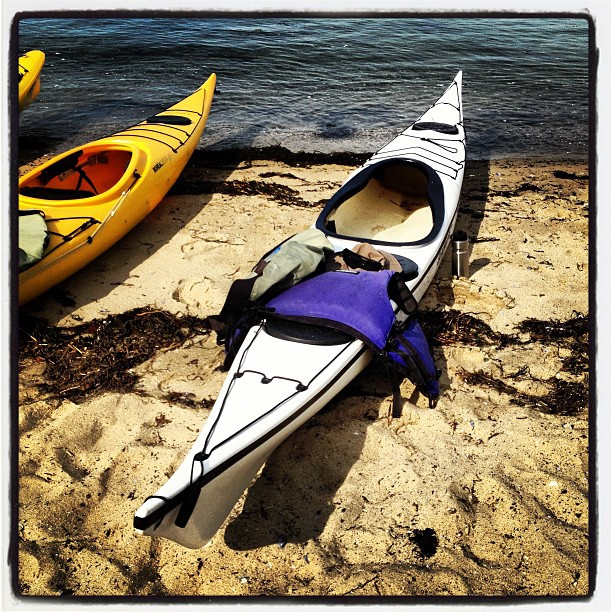

In [50]:
temp = test_df.sample(2986).images.iloc[0]
Image.open(temp).convert("RGB")

In [51]:
tokenizer.decode(t.generate(feature_extractor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])

'<s><s>a white surfboard with a man in a white boat <e></s>'